# Wikipedia feature engineering
The goal of this notebook is to experiment with some new features extracted from Wikipedia.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import urllib.request
import json
import sys
import re
sys.path.append('./helpers/')
sys.path.append('./feature_engineering/')
import names
import helpers

reload(helpers)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lucastrg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lucastrg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'helpers' from '/home/lucastrg/FLEP/MA1/ADA/ada-2021-project-adada-sur-mon-bidet/./helpers/helpers.py'>

## Pre-Processing
We will remove all the quotes without a speaker, and we will extract the set of all the speakers and QIDs of the sampled rows.
We then fetch a json of each speaker's whole page as well as all its PIDs and RIDs (these 2 IDs are not yet in use)

In [ ]:
df = helpers.get_samples(num_samples=10000, random=True)

In [ ]:
df=df[df["speaker"]!="None"]

In [4]:
len(df)

5978

Not so bad ! About 60% of the rows are kept.

In [5]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
7,2020-01-17-000357,[ The delay ] will have an impact [ on Slough ...,Dexter Smith,[Q5268447],2020-01-17 13:03:00,1,"[[Dexter Smith, 0.924], [None, 0.076]]",[http://www.sloughexpress.co.uk/gallery/slough...,E
16,2020-01-08-000594,"11 straight weeks of pre-season,",Aphelele Fassi,[Q56255401],2020-01-08 10:22:11,1,"[[Aphelele Fassi, 0.9033], [None, 0.0967]]",[https://www.sport24.co.za/Rugby/SuperRugby/sh...,E
33,2020-01-20-000982,a host of other protections,Debbie Lesko,[Q16731415],2020-01-20 15:32:48,1,"[[Debbie Lesko, 0.4784], [None, 0.4105], [Ed M...",[https://www.cleveland.com/open/2020/01/the-eq...,E
34,2020-02-29-000491,a lack of resources and government funding,Paul Harvey,"[Q16195572, Q16204369, Q39074951, Q47350253, Q...",2020-02-29 00:13:45,1,"[[Paul Harvey, 0.9212], [None, 0.0788]]",[http://basingstokegazette.co.uk/news/18270936...,E
37,2020-01-03-001237,A lot of Americans [ were ] upset that this wa...,Julián Castro,[Q970720],2020-01-03 00:00:00,1,"[[Julián Castro, 0.4781], [None, 0.4384], [Dav...",[http://keranews.org/post/juli-n-castro-ends-2...,E


In [6]:
qids=list(set(df["qids"].to_numpy().sum()))
speakers=list(set(df["speaker"]))

In [7]:
len(speakers)

4898

In [8]:
request_template= "https://www.wikidata.org/wiki/Special:EntityData/{}.json"
request_template2="https://en.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&titles={}&formatversion=2&rvprop=content&rvslots=*"
request_template3="https://en.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&pageids={}&formatversion=2&rvprop=content&rvslots=*"


In [9]:
invalid_qids=[]
for qid in qids[:10]:
   try :
      with urllib.request.urlopen(request_template.format(qid)) as response:
         raw_data = response
         data = json.load(raw_data)
         data.keys()
   except urllib.request.HTTPError :
      invalid_qids.append(qid)


      #print(json.dumps(data, indent=2, sort_keys=True))
      

Doesn't work atm, not really useful so might drop

In [12]:
invalid_qids=[]
for qid in qids[:10]:
   try :
      with urllib.request.urlopen(request_template3.format(qid_to_rid[qid])) as response:
         raw_data = response
         data = json.load(raw_data)
         data.keys()
   except urllib.request.HTTPError :
      invalid_qids.append(qid)


      #print(json.dumps(data, indent=2, sort_keys=True))
      

NameError: name 'qid_to_rid' is not defined

In [ ]:
data

{'batchcomplete': True,
 'query': {'pages': [{'pageid': 1426072190, 'missing': True}]}}

#Wikipedia data fetching
Fetches all we need to know about a speaker (using their name). Handles one redirection if needed 

In [13]:
invalid_speakers=[]
speaker_content={}
for speaker in speakers[:2000]:
   try :
      with urllib.request.urlopen(request_template2.format(urllib.parse.quote(speaker))) as response:
         raw_data = json.load(response)["query"]["pages"][0]
         
         if raw_data.get("missing",False):
            invalid_speakers.append(speaker)
         else:
            content = raw_data["revisions"][0]["slots"]["main"]["content"]
            if re.search("^'''{}''' may refer to".format(speaker),content): #Drop disambiguation pages
               invalid_speakers.append(speaker)

            else:
               if re.search("(^#REDIRECT \[\[)([A-Za-z 'À-ÿZİı.-]*)", content): #Allows to fix most redirecting problems 
                  speaker_alt = re.search("(^#REDIRECT \[\[)([A-Za-z 'À-ÿZİı.-]*)", content).group(2)
                  print("Redirect ", speaker ,"->",speaker_alt) #Je laisse le print parce qu'il est satisfaisant
                  if speaker_alt:
                     with urllib.request.urlopen(request_template2.format(urllib.parse.quote(speaker_alt))) as response:
                        raw_data = json.load(response)["query"]["pages"][0]
                        if raw_data.get("missing",False):
                           invalid_speakers.append(speaker)
                        else:
                           content = raw_data["revisions"][0]["slots"]["main"]["content"]
                  else :
                     content = "ERROR"
               speaker_content[raw_data["title"]]=content
            
   except urllib.request.HTTPError :
      invalid_speakers.append(speaker)
      

Redirect  Clara Kramer -> Clara's War
Redirect  Jeffrey Mims -> D. Jeffrey Mims
Redirect  Cesar Diaz -> César Díaz
Redirect  Matty Healy -> The 
Redirect  Stephane Dujarric -> Stéphane Dujarric
Redirect  Darion Anderson -> Jake Anderson 
Redirect  Joe Giudice -> Teresa Giudice
Redirect  Bob Miller -> Robert Miller
Redirect  V Srinivasan -> V. Srinivasan
Redirect  Mick Cronin -> Michael Cronin
Redirect  Bill O'Brien -> William O'Brien 
Redirect  Bobby James -> Bob James
Redirect  Kim Kardashian West -> Kim Kardashian
Redirect  Bill Chapman -> William Chapman
Redirect  Georgina Wood -> Georgina Theodora Wood
Redirect  Kareena Kapoor Khan -> Kareena Kapoor
Redirect  Mike White -> Michael White
Redirect  Dave Roberts -> David Roberts
Redirect  Sinead O'Connor -> Sinéad O'Connor
Redirect  Mike Green -> Michael Green
Redirect  Bill Hoffman -> William Hoffman
Redirect  Tedros Adhanom Ghebreyesus -> Tedros Adhanom
Redirect  Danny Garcia -> Daniel García
Redirect  Stephen Townsend -> Stephen J.

In [14]:
len(speaker_content)

1622

We manage to fetch around 75% of the wikipedia page that we were looking for ! 
However we can notice a small percentage of rows that are considered as valid to be completely wrong. Since we fetch the jsons using the name of the speaker, we can either have trouble resolving homonyms, or simply suffer from badly assigned names (i.e. "Theater Director")

## Political Side assignation
Here we're guessing the political side of each speaker with somewhat good accuracy. We use 2 different strategies, if the speaker has a well filled in wikipedia page, we can simply find its current political party. If not, we're using a surprisingly alright heuristic, we simply count the occurences of words assigned to democrats (i.e. "left-wing", "liberal", ...) and republicans, and compare the 2 counts.

NB: There is obviously one major assumption that speaker belong exclusively to either of these two (or none). However, even in the US, some speakers are "in the middle". 

It should also be noted that some speakers are not American, we however found that our heuristic still matched those speakers with conservatives view to the Republican and vice-versa). We shall in the next milestone investigate further and perhaps adopt a deeper model.

In [37]:
def pol_compass_from_wiki(speakers_content, discrete = True):
    if discrete:
        dem_words=["democrat", "left-wing", "liberal"]
        rep_words =["republican", "conservative", "right-wing"]


        for speaker in speakers_content:
            yielded = False
            s= speakers_content[speaker].lower()

            for line in s.split("\n"):
                if "| party" in line:
                    if any(x in line for x in dem_words):
                        yield speaker, ("Democrat", -1)
                        yielded = True
                    elif any(x in line for x in rep_words):
                        yielded = True
                        yield speaker, ("Republican", -1)
                
            if not yielded:

                dem= sum(s.count(x) for x in dem_words)
                rep= sum(s.count(x) for x in rep_words)
                total = rep+dem
                if total:
                    yield speaker, ("Democrat" if dem>rep else "Republican", total)
    else:
        dem_words=["democrat", "left-wing", "liberal"]
        rep_words =["republican", "conservative", "right-wing"]

        for speaker in speakers_content:
            yielded = False
            s= speakers_content[speaker].lower()

            for line in s.split("\n"):
                if "| party" in line:
                    if any(x in line for x in dem_words):
                        yield speaker, (1,0, -1)
                        yielded = True
                    elif any(x in line for x in rep_words):
                        yielded = True
                        yield speaker, (0,1, -1)
                
            if not yielded:

                dem= sum(s.count(x) for x in dem_words)
                rep= sum(s.count(x) for x in rep_words)
                total = rep+dem
                if total:
                    yield speaker, (dem/total,rep/total, total)



In [38]:
speaker_wing= dict(pol_compass_from_wiki(speaker_content))
len(speaker_wing)

501

## Gender assignation

In order to guess the gender if the speakers, we again use 2 strategies. At first, we try guessing the gender by counting occurences of gendered pronoums, but if we don't get any, we train a classifier, which solely uses the name of the speaker to guess the gender (thus with pretty bad accuracy ~70%) 

In [39]:
from nltk.corpus import names
from nltk import NaiveBayesClassifier as NBC
from nltk import classify
import nltk
nltk.download('names')

import random

[nltk_data] Downloading package names to /home/lucastrg/nltk_data...
[nltk_data]   Package names is already up-to-date!


For the classifier we use both the whole name as well as only the last letter

In [40]:
def gender_features(word):
    return {"whole name" : word, "lastletter" : word[-1]}

Training set loading and parsing

In [41]:
femaleNames = [ (name, "female") for name in names.words("female.txt") ]
maleNames = [ (name, "male") for name in names.words("male.txt") ]
allNames = maleNames + femaleNames
random.shuffle(allNames)

Actually training the classifier

In [42]:
featureData = [(gender_features(namelist), gender) for (namelist, gender) in allNames ]
test_data = featureData[:500]
train_data = featureData[500:]
classifier = NBC.train(train_data)

In [43]:
def gender_from_wiki(speaker_content):
    he_words=[" he ", " him", " him"] #The spaces are important, don't modify
    she_words =[" she ", " her"]
    they_words=[" they ", " them"]

    for speaker in speaker_content:
        s= speaker_content[speaker].lower()

        he= sum(s.count(x) for x in he_words)
        she= sum(s.count(x) for x in she_words)
        they= sum(s.count(x) for x in they_words)
        total = he+she+they

        if True:
            if total==0:
                 yield (speaker, classifier.classify(gender_features(speaker.split()[0])))
            elif he == max(he,she,they):
                yield(speaker, "male")
            elif she == max(he,she,they):
                yield(speaker, "female")
            else:
                yield(speaker, "other") 
        if False and total:
            yield speaker, (he/total,she/total, they/total, total)


In [44]:
speaker_gender = dict(gender_from_wiki(speaker_content))
len(speaker_gender)

1622

In [45]:
tmp = []
for speaker, gender in speaker_gender.items():
    tmp.append(gender)
np.unique(tmp, return_counts=True) #Snif

(array(['female', 'male', 'other'], dtype='<U6'), array([ 364, 1254,    4]))

As we can see, only 20% of the speakers, are female.

## Age assignation
Much easier to do, we can most of the time get a solid birth date and compute the age of the speaker (not precisely, we only use the year, since we're more interested about seeing general trends rather than precise assignation)

In [46]:
def age_from_wiki(speaker_content):
    count = 0

    for speaker in speaker_content:
        s= speaker_content[speaker].lower().split("\n")
        for line in s:
            if "birth_date" in line:
                    
                    match = re.match("^(\|birth_date={{birthdateandage\|(\w*=\w*\|)?)([0-9]*)\|([0-9]*)\|([0-9]*)", line.replace(" ",""))
                    if match:
                        age = 2022-int(match.group(3))
                        yield(speaker, age)
                    else : 
                        match = re.match("^(\|birth_date={{birthdate\|(\w*=\w*\|)?)([0-9]*)\|([0-9]*)\|([0-9]*)", line.replace(" ",""))
                        if match:
                            age = 2022-int(match.group(3))
                            yield(speaker, age)
                        else :
                            match = re.match("^(\|birth_date={{birthyearandage\|(\w*=\w*\|)?)([0-9]*)", line.replace(" ",""))
                            if match:
                                age = 2022-int(match.group(3))
                                yield(speaker, age)     
                            else:
                                count +=1


In [47]:
speaker_age = dict(age_from_wiki(speaker_content))

In [48]:
len(speaker_age)

1197

Text(0, 0.5, 'Count')

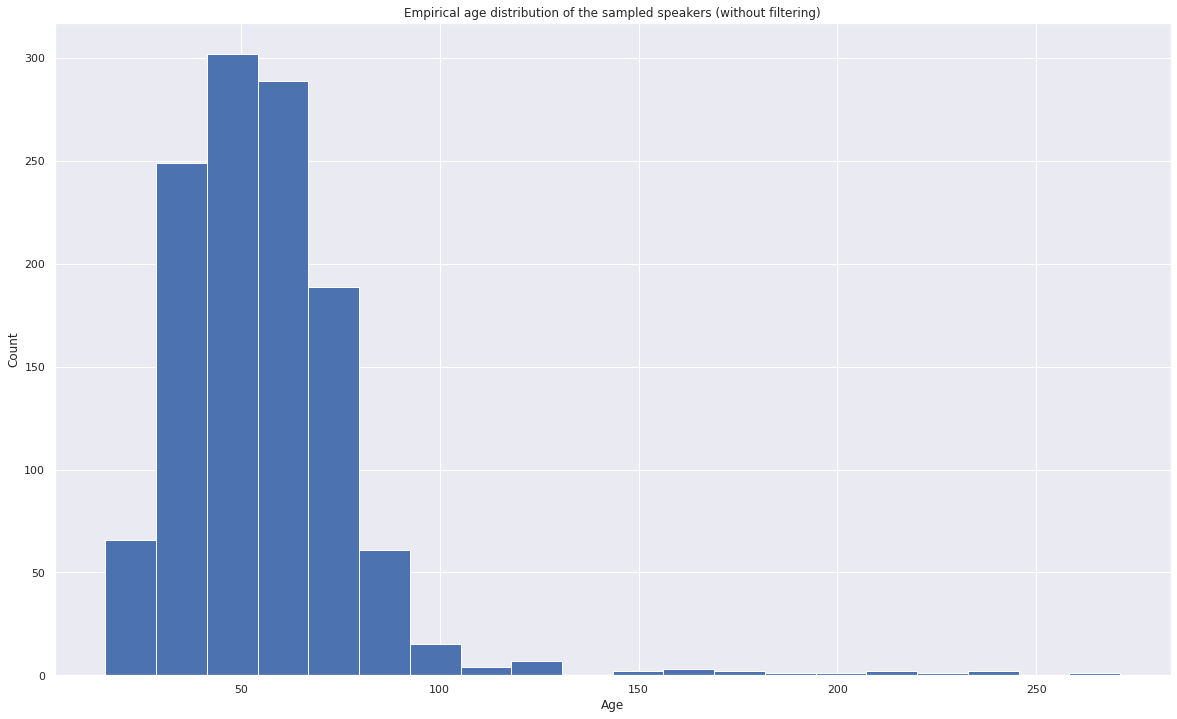

In [49]:
plt.hist(speaker_age.values(), bins=20)
plt.title("Empirical age distribution of the sampled speakers (without filtering)")
plt.xlabel("Age")
plt.ylabel("Count")

In [50]:
wing = []
ages = []
gender = []


for speaker in speaker_content:
    if speaker in speaker_age.keys() and speaker in speaker_gender.keys() and speaker in speaker_wing.keys() and speaker_age[speaker]<120:
 
        ages.append(speaker_age[speaker])
        wing.append(speaker_wing[speaker][0])
        gender.append(speaker_gender[speaker])


Text(0, 0.5, 'Count')

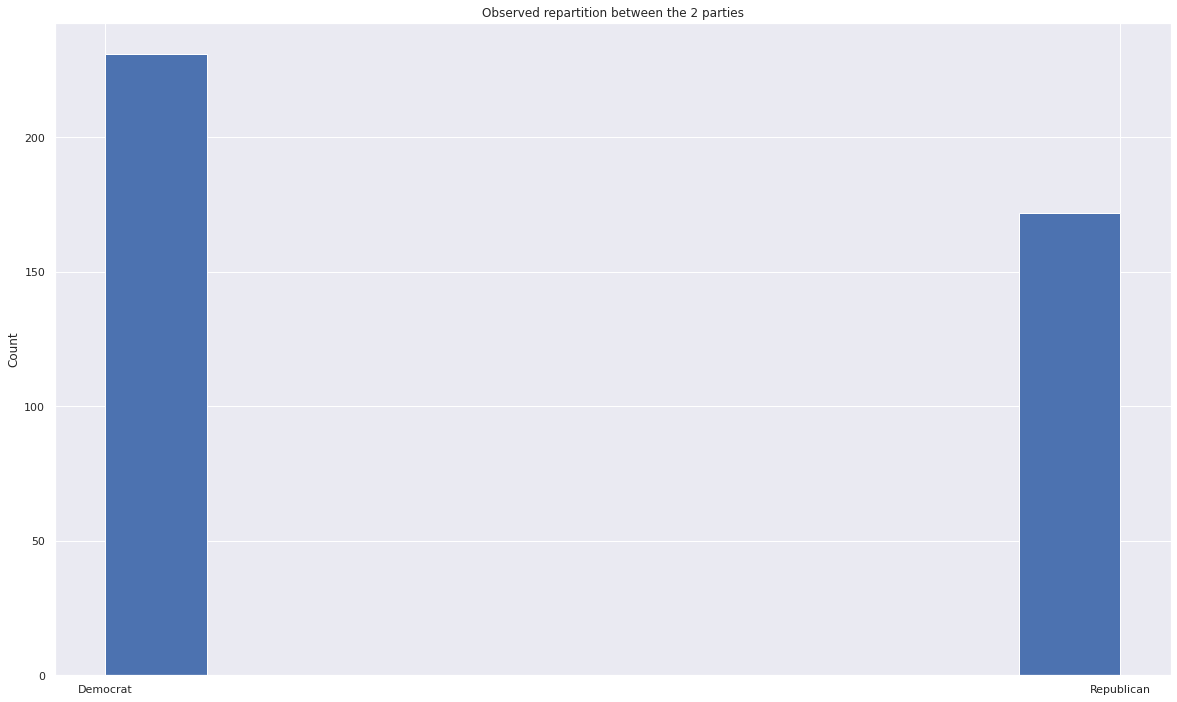

In [52]:
plt.hist(wing)
plt.title("Observed repartition between the 2 parties")
plt.ylabel("Count")

In order to get a more precise view of the age of speakers that could have contributed to the climate change question, we filtered speakers over 120 years old

Text(0, 0.5, 'Count')

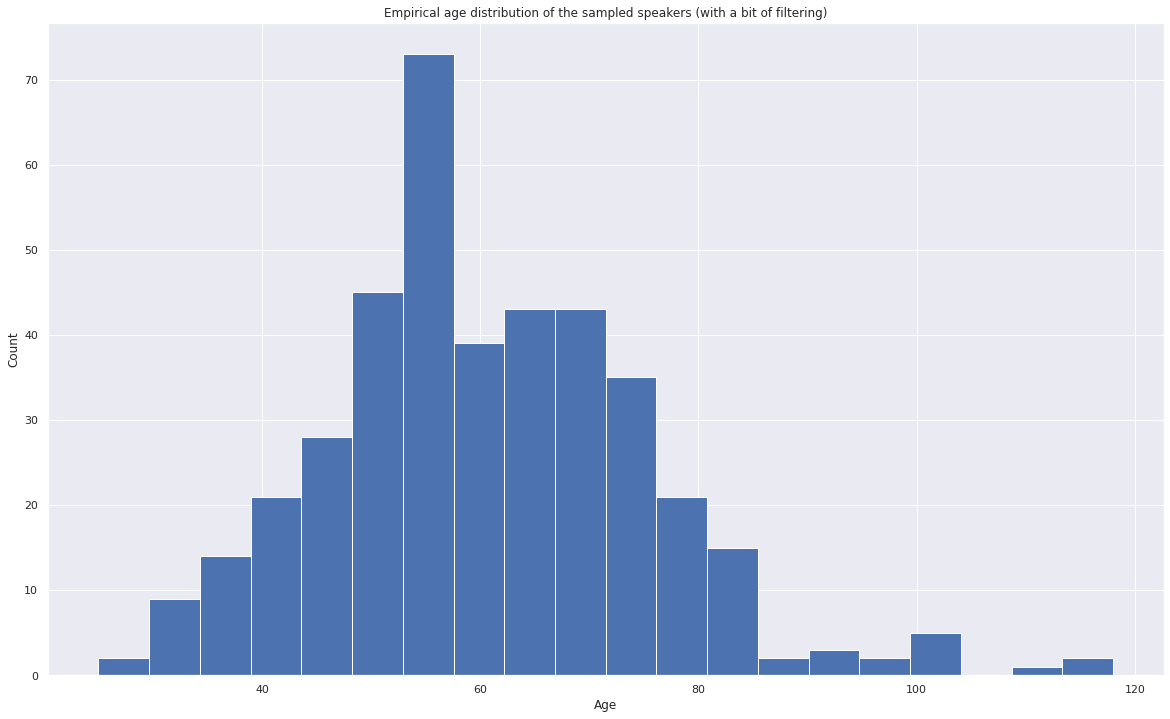

In [55]:
plt.hist(ages,bins=20)
plt.title("Empirical age distribution of the sampled speakers (with a bit of filtering)")
plt.xlabel("Age")
plt.ylabel("Count")

In [57]:
big_dict={}
for speaker in speaker_content:
    if speaker in speaker_age.keys() and speaker in speaker_gender.keys() and speaker in speaker_wing.keys() and speaker_age[speaker]<120:
        big_dict[speaker]=(speaker_age[speaker], speaker_gender[speaker], speaker_wing[speaker][0],speaker_wing[speaker][1])
        

In [58]:
df = pd.DataFrame.from_dict(big_dict, orient="index", columns=["age", "gender", "wing", "political_count"])

In [59]:
df.wing = df.wing.astype( "category")
df.gender = df.gender.astype("category")

Text(0.5, 0.98, 'Age and gender distribution for each major political wing')

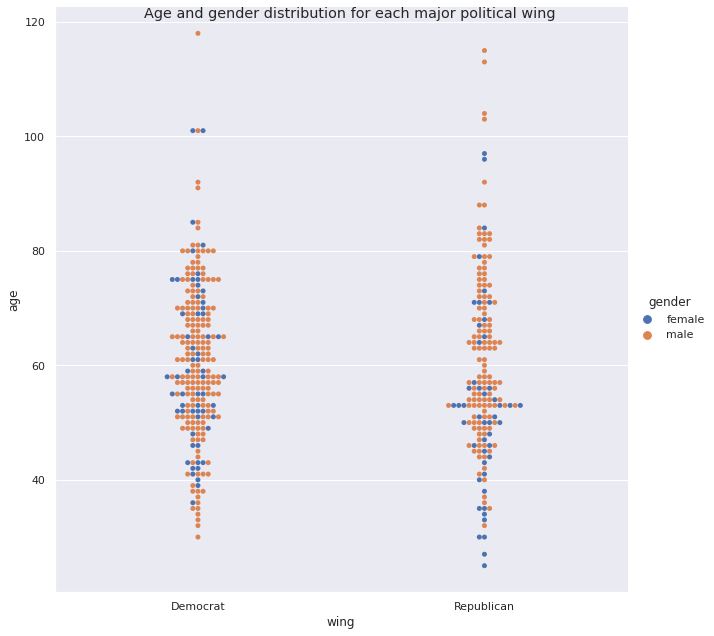

In [65]:
sns.set(rc={'figure.figsize':(20,12)})
sns.catplot(x="wing", y="age", hue="gender", kind="swarm", data=df, height=9).fig.suptitle("Age and gender distribution for each major political wing")

Text(0.5, 1.0, 'Age distribution of each major political wing')

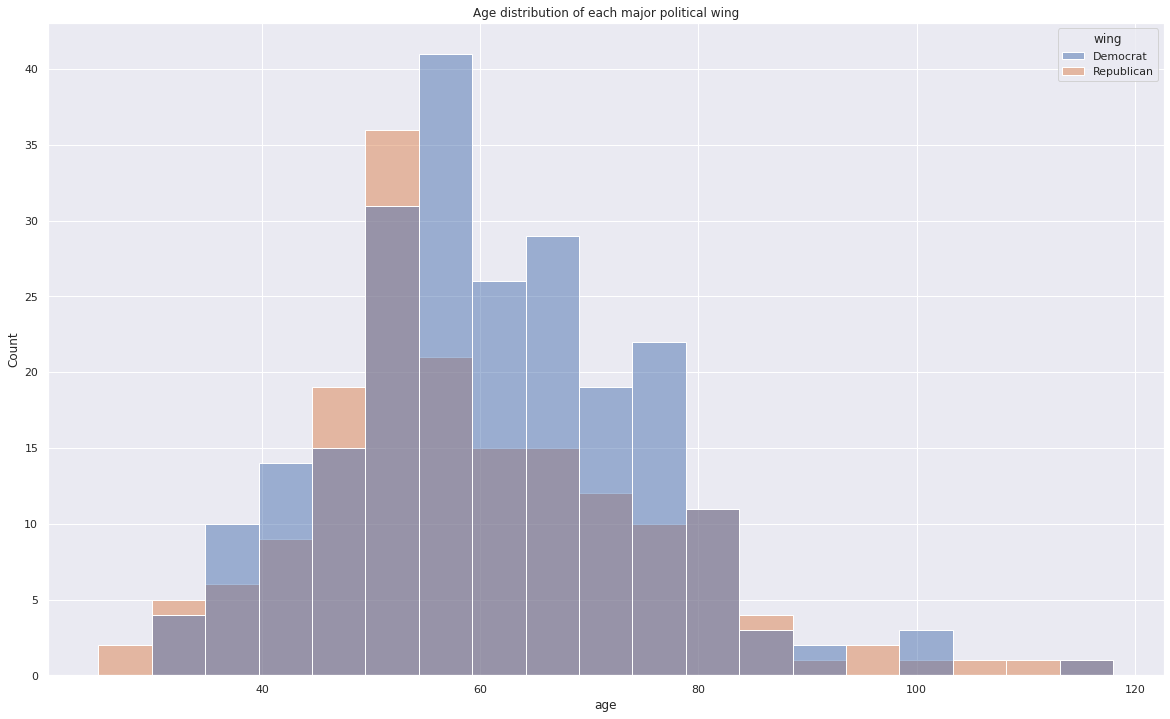

In [68]:
sns.histplot(data=df, x="age", hue="wing").set_title("Age distribution of each major political wing")

Text(0.5, 1.0, 'Age distribution of each assigned gender')

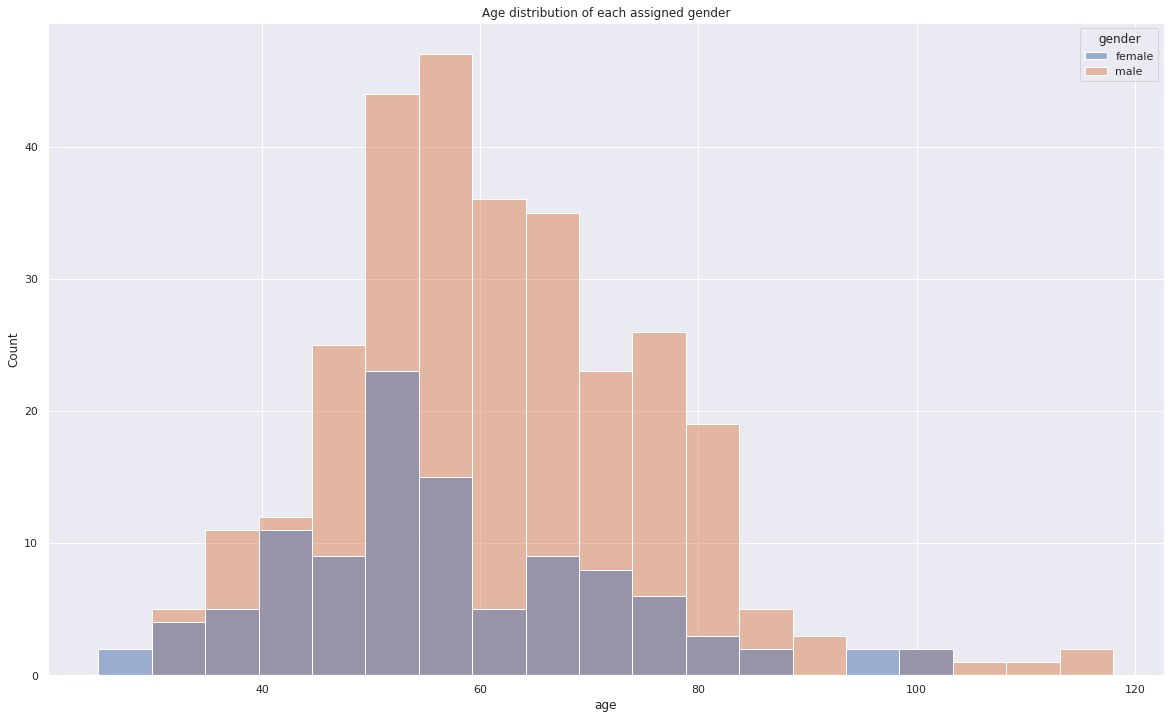

In [69]:
sns.histplot(data=df, x="age", hue="gender").set_title("Age distribution of each assigned gender")